In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp_spec
import scipy as sp

# Importing the data

In [2]:
data = pd.read_csv("HistoricalData_MSFT.csv")
data.set_index("Date", inplace=True)
close_last_col = [ float(val.replace("$", "")) for val in data["Close/Last"] ]
data["Close/Last"] = close_last_col
y = data["Close/Last"].copy()
data

,Close/Last,Volume,Open,High,Low
Date,,,,,
02/27/2025,392.53,21127410,$401.265,$405.74,$392.17
02/26/2025,399.73,19618950,$398.01,$403.60,$394.245
02/25/2025,397.90,29387400,$401.10,$401.915,$396.70
02/24/2025,404.00,26443660,$408.51,$409.37,$399.32
02/21/2025,408.21,27524800,$417.335,$418.048,$407.89
...,...,...,...,...,...
03/05/2024,402.65,26919180,$413.96,$414.25,$400.64
03/04/2024,414.92,17595960,$413.44,$417.35,$412.32
03/01/2024,415.50,17823450,$411.27,$415.87,$410.88


In [3]:
data.dtypes

Close/Last    float64
Volume          int64
Open           object
High           object
Low            object
dtype: object

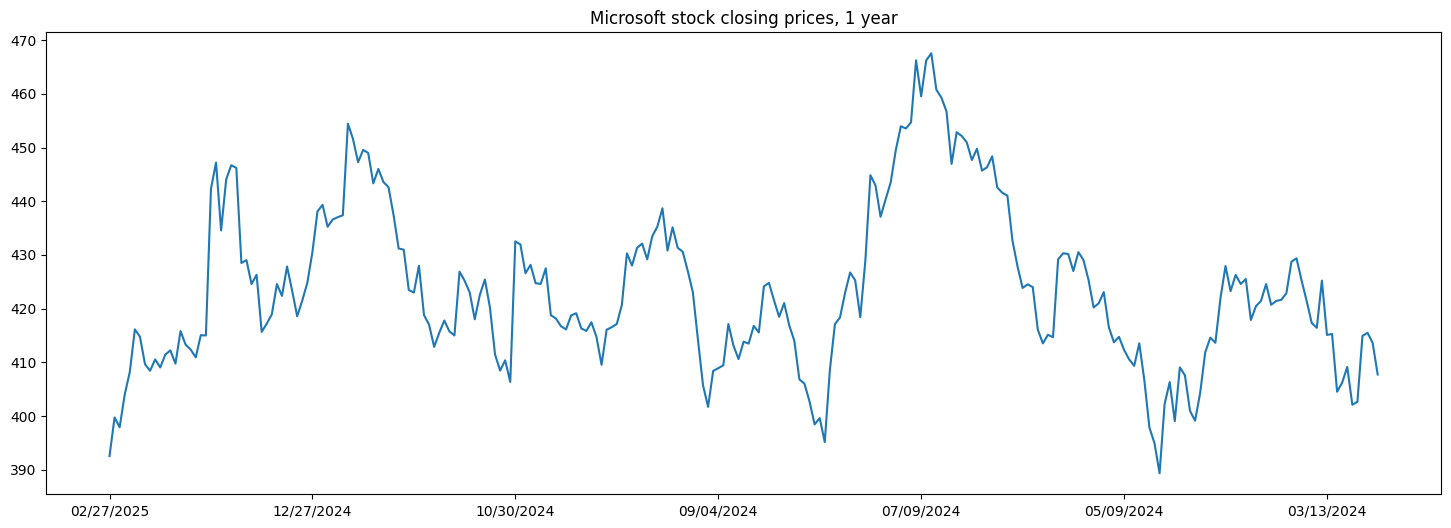

In [4]:
plt.figure(figsize = (18,6))
plt.plot(y)
plt.title("Microsoft stock closing prices, 1 year")
plt.xticks(np.arange(0,len(data),40))
#plt.savefig("microsoft_stock_1year.pdf", bbox_inches="tight")
plt.show()

# GP Regression for prediction Microsoft stock 50 days ahead

In [5]:
x_test = np.arange(len(y)) 
x_train = np.arange(len(y)-50) # predicting 10 days ahead
y_train = y[0:len(y)-50]
y_test = y.copy()

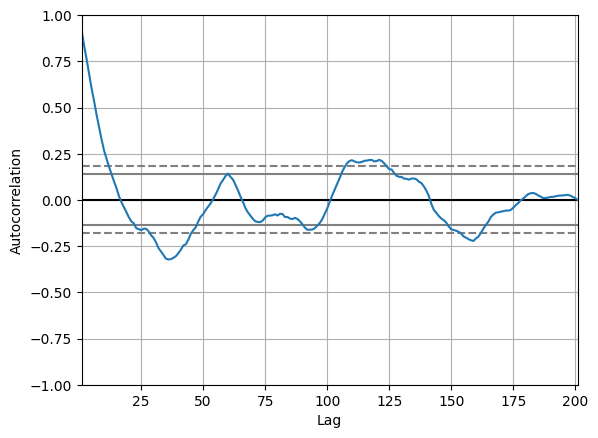

In [6]:
# Plotting autocorrelation plot to help defining the correlation length for covariance kernel
plt.figure()
pd.plotting.autocorrelation_plot(y_train)
plt.show()

In [7]:
# covariance kernel: exponential with l=50
l = 50
def exp_kernel(x1, x2):
    euc_dist = np.sqrt( (x1 - x2)**2 )
    out = np.exp(-euc_dist/(2*l**2))
    return out

In [8]:
# forming the covariance matrix of the process
K_X = np.zeros((len(x_train),len(x_train)))
for i in range(0,len(x_train)):
    for j in range(0,len(x_train)):
        K_X[i,j] = exp_kernel(x_train[i], x_train[j])

K_X_test = np.zeros((len(x_test),len(x_train)))
for i in range(0,len(x_test)):
    for j in range(0,len(x_train)):
        K_X_test[i,j] = exp_kernel(x_test[i], x_train[j])

K_X_test_test = np.zeros((len(x_test),len(x_test)))
for i in range(0,len(x_test)):
    for j in range(0,len(x_test)):
        K_X_test_test[i,j] = exp_kernel(x_test[i], x_test[j])

In [9]:
mu_pred = K_X_test@np.linalg.inv(K_X + 0.00006*np.eye(len(x_train)))@y_train
cov_pred = K_X_test_test - K_X_test@np.linalg.inv(K_X + 0.00006*np.eye(len(x_train)))@K_X_test.transpose()

In [10]:
# sampling
N_samples = 5
samples = np.random.multivariate_normal(mean=mu_pred, cov=cov_pred, size=N_samples)

In [11]:
# function to get the diagonal values of covariance matrix
def get_diagonal(X):
    n = X.shape[0]
    out = np.zeros(n)
    ind = 0
    for i in range(0,n):
        for j in range(0,n):
            if i == j:
                out[ind] = X[i,j]
                ind += 1

    return out

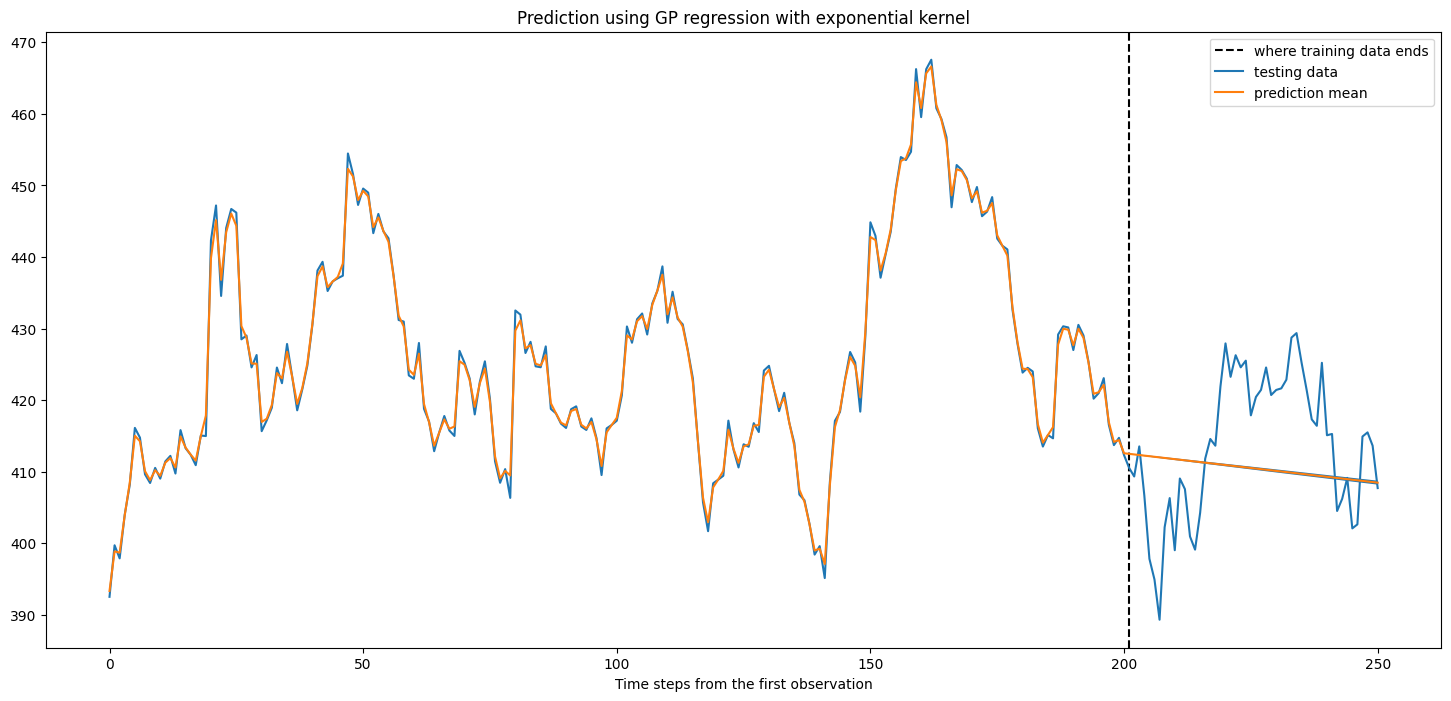

In [12]:
plt.figure(figsize=(18,8))
plt.axvline(len(y)-50, linestyle="--", color="k", label="where training data ends")
plt.plot(x_test, y_test, label="testing data")
plt.plot(x_test, mu_pred, label="prediction mean")

#for i in range(0,N_samples):
#    plt.plot(x_test, samples[i,:], linestyle="--", alpha=0.8)

plt.title("Prediction using GP regression with exponential kernel")
plt.xlabel("Time steps from the first observation")
plt.fill_between(x_test, mu_pred + 1.96*np.sqrt(get_diagonal(cov_pred)), mu_pred - 1.96*np.sqrt(get_diagonal(cov_pred)))
plt.legend()
plt.show()

Prediction mean seems to predict somehow well the price 50 days ahead although the uncertainty of the prediction seems far too low (almost zero).

# Different kernels: